# Uber Fares Predictions

## Preparing The Data

### Import Relevant Libraries

In [33]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

### Configuring Libraries

In [34]:
pd.options.mode.chained_assignment = None

# Use a fixed seed to make results reproducible
np.random.seed(873409)

### Loading The Dataset

Note: Kaggle does not support importing directly so the .csv must be in the same directory as the notebook

In [35]:
df = pd.read_csv("uber.csv")

### Cleaning The Dataset

In [36]:
# Define coordinate bounds
longitude_min = -180
longitude_max = 180
latitude_min = -90
latitude_max = 90

# Dropping unrelated features
df.drop(['Unnamed: 0', 'key'], inplace=True, axis=1)

# Remove na values
df.dropna(inplace=True)

# Remove faulty data
df = df[df.fare_amount > 0]

df = df[
    (df.pickup_longitude >= longitude_min) & 
    (df.pickup_longitude <= longitude_max) & 
    (df.pickup_latitude >= latitude_min) & 
    (df.pickup_latitude <= latitude_max)
]

df = df[df.passenger_count > 0]

# Convert date to int
df.pickup_datetime = pd.to_numeric(pd.to_datetime(df.pickup_datetime))

#### Creating A Slightly Stricter Dataframe For EDA Graph Pairs

In [37]:
filtered_df = df[df.fare_amount < 100]

## Exploratory Data Analysis

Note: For all graphs, a second one is generated with an upper limit of $100USD so that the patterns are more easily observable at values closer to the mean.

### Exploring The Data

In [38]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 199259 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199259 non-null  float64
 1   pickup_datetime    199259 non-null  int64  
 2   pickup_longitude   199259 non-null  float64
 3   pickup_latitude    199259 non-null  float64
 4   dropoff_longitude  199259 non-null  float64
 5   dropoff_latitude   199259 non-null  float64
 6   passenger_count    199259 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 12.2 MB


None

In [39]:
display(df.head())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,1431028326000000000,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,1247861096000000000,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,1251150300000000000,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,1246004541000000000,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,1409248020000000000,-73.925023,40.744085,-73.973082,40.761247,5


In [40]:
display(df.describe())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199259.000000,1.992590e+05,199259.000000,199259.000000,199259.000000,199259.000000,199259.000000
mean,11.369411,1.332473e+18,-72.504195,39.919184,-72.517762,39.925768,1.690488
std,9.905917,5.830927e+16,10.442166,6.127711,10.509222,6.198131,1.384791
min,0.010000,1.230773e+18,-93.824668,-74.015515,-737.916665,-74.015750,1.000000
25%,6.000000,1.282489e+18,-73.992064,40.734792,-73.991409,40.733828,1.000000
50%,8.500000,1.332573e+18,-73.981825,40.752582,-73.980094,40.753042,1.000000
75%,12.500000,1.382305e+18,-73.967161,40.767155,-73.963663,40.767995,2.000000
max,499.000000,1.435708e+18,40.808425,48.018760,40.831932,493.533332,208.000000


In [41]:
display(Markdown("> Data Shape: {}".format(df.shape)))

> Data Shape: (199259, 7)

### Histogram of Fare Amounts

As we can see from the resultant graph, majority of the fares are distributed in the range $0 - $25.

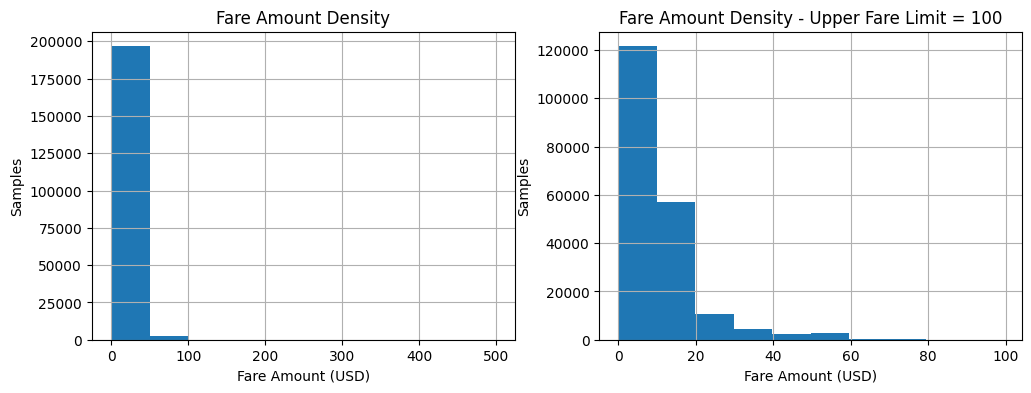

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)
df.fare_amount.hist()
plt.title('Fare Amount Density')
plt.xlabel('Fare Amount (USD)')
plt.ylabel('Samples')
plt.subplot(122)
plt.title('Fare Amount Density - Upper Fare Limit = 100')
plt.xlabel('Fare Amount (USD)')
plt.ylabel('Samples')
filtered_df.fare_amount.hist()
plt.show()

### Scatter Plot With Line of Best Fit of Fare Amounts Over Time

From these graphs, it’s a little hard to visually see any overall correlation between Datetime and fare amount. The main observation that can be drawn is the increase in fare amounts near datatime 1.35e18 which corresponds to some time in 2012 where there was likely a mark up in service costs. Other observations will likely need to be left to be seen in the correlation matrix

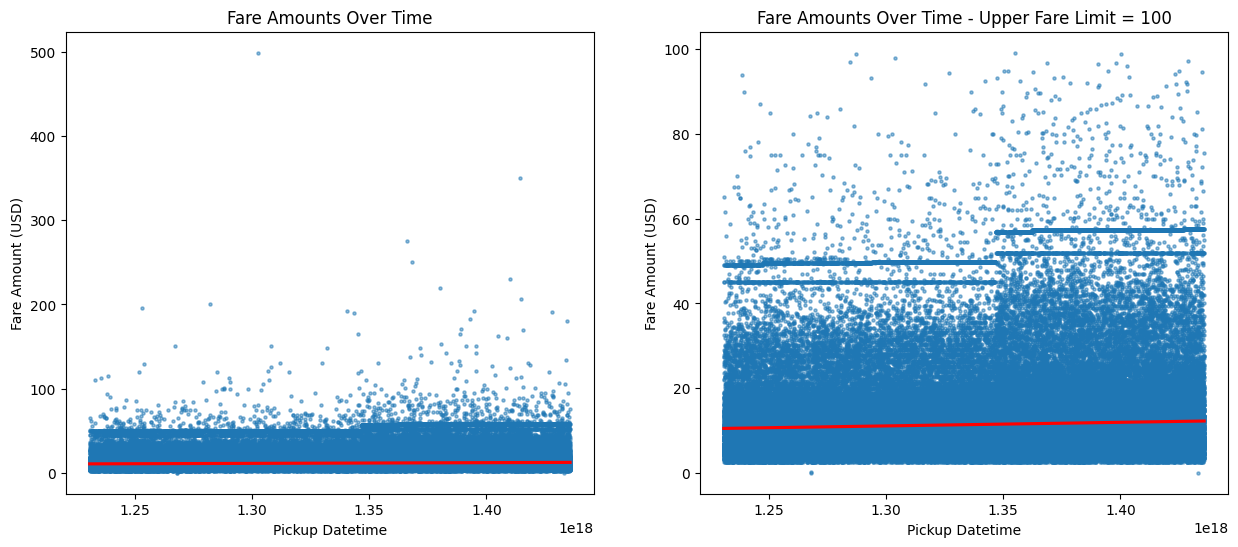

In [43]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.regplot(x='pickup_datetime', y='fare_amount', data=df, scatter_kws={'s': 5, 'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Fare Amounts Over Time')
plt.xlabel('Pickup Datetime')
plt.ylabel('Fare Amount (USD)')
plt.subplot(122)
sns.regplot(x='pickup_datetime', y='fare_amount', data=filtered_df, scatter_kws={'s': 5, 'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Fare Amounts Over Time - Upper Fare Limit = 100')
plt.xlabel('Pickup Datetime')
plt.ylabel('Fare Amount (USD)')
plt.show()

### Scatter Plot of Fare Amounts Against Pickup Locations

The following graph displays the distribution of fares with respect to location.  It helps to identify any geographical patterns or areas with higher fares. There doesn't seem to be a clear correlation between geographical location and price. It should be noted however that in the second graph, there is a siginificantly higher cost fare in the bottom right however those coordinates are in Antartica so it's legitemacy is questionable.

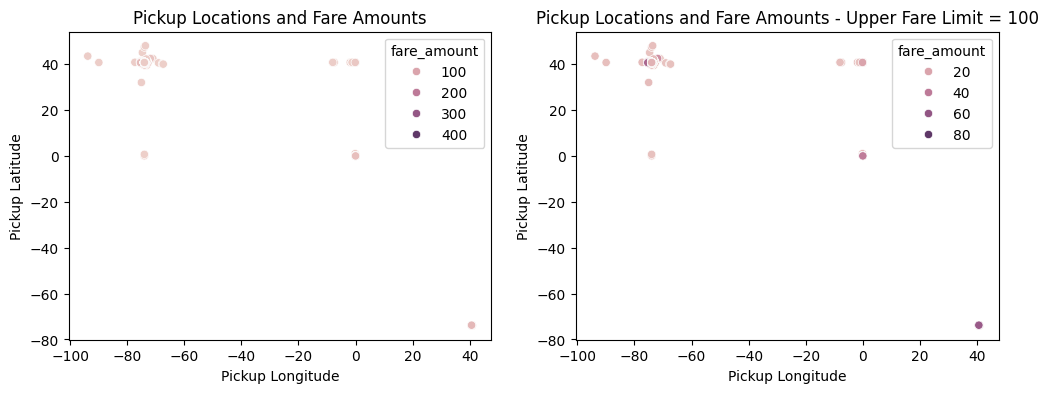

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='fare_amount', data=df)
plt.title('Pickup Locations and Fare Amounts')
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')
plt.subplot(122)
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='fare_amount', data=filtered_df)
plt.title('Pickup Locations and Fare Amounts - Upper Fare Limit = 100')
plt.xlabel('Pickup Longitude')
plt.ylabel('Pickup Latitude')
plt.show()

### Correlation

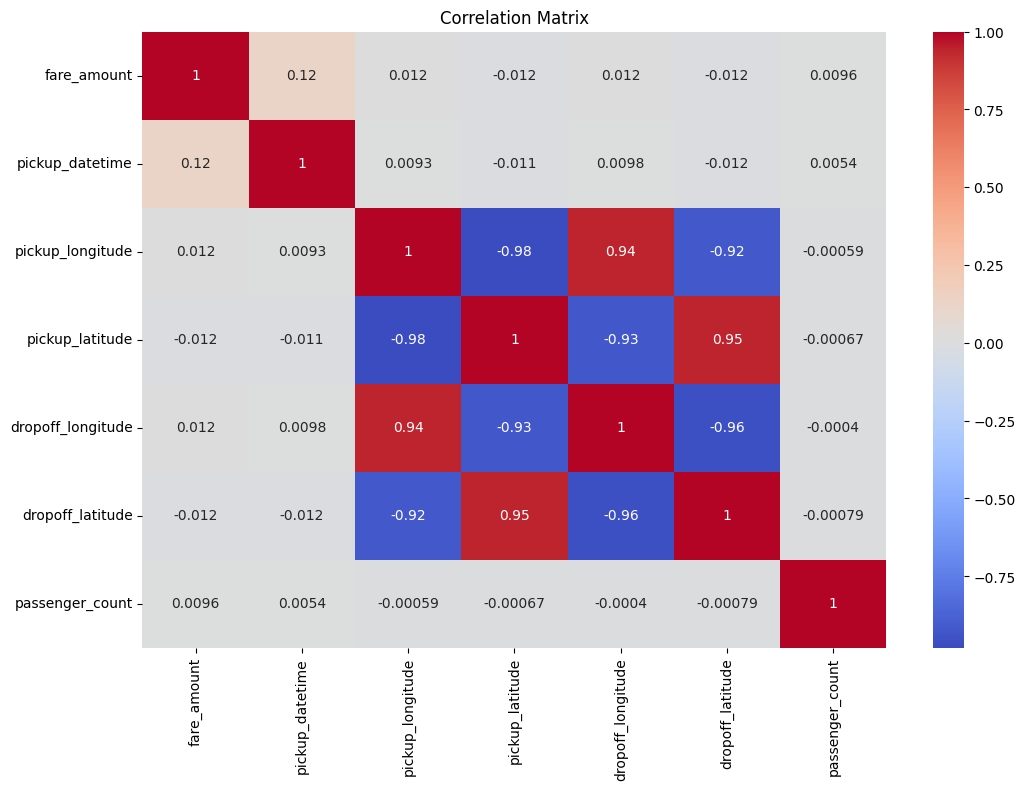

In [45]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

From this matrix we can conclude that the fare seems to be reliant more on pickup date and time as compared to other variables, with pickup longitude as the runner-up.

## Preparing Data For Regression

### Separate Target Feature

In [46]:
dft = df.fare_amount
df.drop(['fare_amount'], inplace=True, axis=1)
display(Markdown("> Feature Set Shape: {}".format(df.shape)))
display(Markdown("> Target Set Shape: {}".format(dft.shape)))

> Feature Set Shape: (199259, 6)

> Target Set Shape: (199259,)

### Apply Pipeline

Note: This code is an adapted version of the code in the end-to-end ML samples on the course website

In [47]:
num_cols = df.select_dtypes(include='number').columns.to_list()

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())

# Use ColumnTransformer to set the estimators and transformations

preprocessing = ColumnTransformer([('num', num_pipeline, num_cols)],
                                    remainder='passthrough'
                                 )

display(preprocessing)

df_prepared = preprocessing.fit_transform(df)

feature_names = preprocessing.get_feature_names_out()
df_prepared = pd.DataFrame(data=df_prepared, columns=feature_names)

display(df_prepared.shape)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['pickup_datetime', 'pickup_longitude',
                                  'pickup_latitude', 'dropoff_longitude',
                                  'dropoff_latitude', 'passenger_count'])])

(199259, 6)

### Split the datasets

In [48]:
df_train, df_test, dft_train, dft_test = train_test_split(df_prepared, dft, test_size=0.2, random_state=42)
display(Markdown("> %s %s %s %s" % (df_train.shape, dft_train.shape, df_test.shape, dft_test.shape)))

> (159407, 6) (159407,) (39852, 6) (39852,)

## Training 3 Different Regression Models

### Multiple Linear Regression

In [49]:
mlr = LinearRegression()
mlr.fit(df_train, dft_train)

LinearRegression()

### Ridge Regression

In [50]:
rr = Ridge()
rr.fit(df_train, dft_train)

Ridge()

### Elastic Net Regression

In [51]:
enr = ElasticNet()
enr.fit(df_train, dft_train)

ElasticNet()

## Comparing Performances Between The Models

### Multiple Linear Regression

In [52]:
mlr_dft_predict = mlr.predict(df_test)

mlr_RMSE = mean_squared_error(dft_test, mlr_dft_predict, squared=False)
mlr_MAE = mean_absolute_error(dft_test, mlr_dft_predict)

display(Markdown("> Multiple Linear Regression RMSE: %s" % mlr_RMSE))
display(Markdown("> Multiple Linear Regression MAE: %s" % mlr_MAE))

> Multiple Linear Regression RMSE: 9.999959878142283

> Multiple Linear Regression MAE: 6.033518385262153

### Ridge Regression

In [53]:
rr_dft_predict = rr.predict(df_test)

rr_RMSE = mean_squared_error(dft_test, rr_dft_predict, squared=False)
rr_MAE = mean_absolute_error(dft_test, rr_dft_predict)

display(Markdown("> Ridge Regression RMSE: %s" % rr_RMSE))
display(Markdown("> Ridge Regression MAE: %s" % rr_MAE))

> Ridge Regression RMSE: 9.999959958084101

> Ridge Regression MAE: 6.033518453483443

### Elastic Net Regression

In [54]:
enr_dft_predict = enr.predict(df_test)

enr_RMSE = mean_squared_error(dft_test, enr_dft_predict, squared=False)
enr_MAE = mean_absolute_error(dft_test, enr_dft_predict)

display(Markdown("> Elastic Net Regression RMSE: %s" % enr_RMSE))
display(Markdown("> Elastic Net Regression MAE: %s" % enr_MAE))

> Elastic Net Regression RMSE: 10.032650021093067

> Elastic Net Regression MAE: 6.061790508287913

### Comparing The Performances using sklearn's scoring

In [55]:
display(Markdown("> Multiple Linear Regression Score: %s" % (mlr.score(df_test, dft_test))))
display(Markdown("> Ride Regression Score: %s" % (rr.score(df_test, dft_test))))
display(Markdown("> Elastic Net Regression: %s" % (enr.score(df_test, dft_test))))

> Multiple Linear Regression Score: 0.0158666835743817

> Ride Regression Score: 0.015866667839637305

> Elastic Net Regression: 0.009421849019126127

## Analysing The Best Performing Model - Multiple Linear Regression

### Calulating Prediction Errors

In [56]:
prediction_errors = dft_test - mlr_dft_predict

### Graphing Predicted vs Actual Values

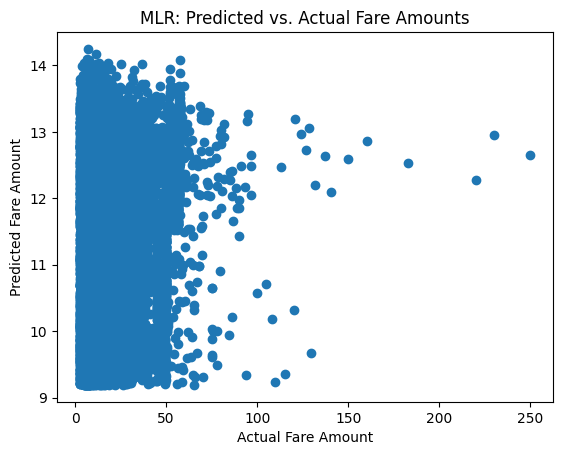

In [57]:
plt.scatter(dft_test, mlr_dft_predict)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("MLR: Predicted vs. Actual Fare Amounts")
plt.show()

### Graphing Scatter Plot of Prediction Errors

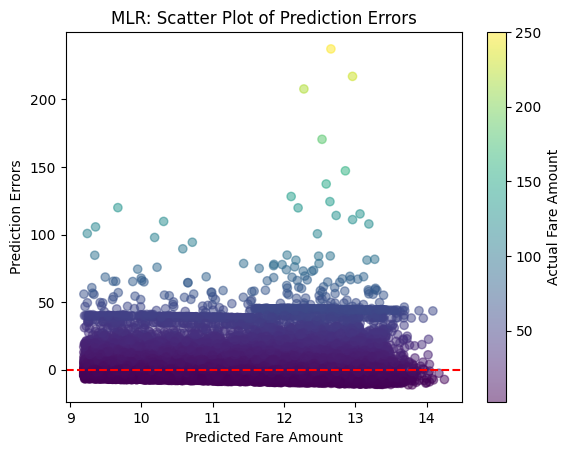

In [58]:
# Scatter Plot of Prediction Errors
plt.scatter(mlr_dft_predict, prediction_errors, c=dft_test, cmap='viridis', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.colorbar(label="Actual Fare Amount")
plt.xlabel("Predicted Fare Amount")
plt.ylabel("Prediction Errors")
plt.title("MLR: Scatter Plot of Prediction Errors")
plt.show()

### Graphing Distribution of Prediction Errors

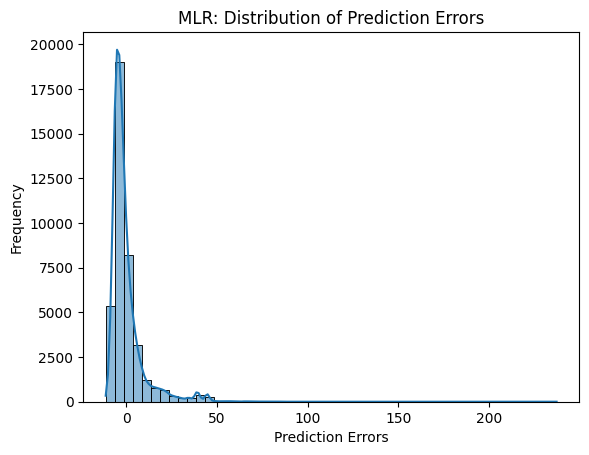

In [59]:
sns.histplot(prediction_errors, bins=50, kde=True)
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("MLR: Distribution of Prediction Errors")
plt.show()

There does not seem to be a clear correlation between the features and the prediction errors which is good in the sense that this means that the model isn't over or under valuing any feature but bad in the sense that this means it is difficult to associate any problematic features in terms of consistency.